# Qudits VS qubits


<img src="https://rqc.ru/static/RQClogo_black_ru.png" alt="drawing" height="300">

## Annotation

The following notebook implements qudits VQC and qubit VQC

Author: Artem Kuzmichev, Quantum Research Scientist, RQC

In [ ]:
!pip install cirq -q --no-warn-conflicts

     |████████████████████████████████| 577 kB 32.9 MB/s 
     |████████████████████████████████| 57 kB 5.3 MB/s 
     |████████████████████████████████| 594 kB 54.4 MB/s 
     |████████████████████████████████| 66 kB 3.5 MB/s 
     |████████████████████████████████| 1.8 MB 16.0 MB/s 
     |████████████████████████████████| 120 kB 51.8 MB/s 
     |████████████████████████████████| 221 kB 66.0 MB/s 
     |████████████████████████████████| 229 kB 44.0 MB/s 
     |████████████████████████████████| 44 kB 1.3 MB/s 
     |████████████████████████████████| 147 kB 46.0 MB/s 
     |████████████████████████████████| 49 kB 5.2 MB/s 
     |████████████████████████████████| 84 kB 3.3 MB/s 
     |████████████████████████████████| 69 kB 7.2 MB/s 
     |████████████████████████████████| 80 kB 8.7 MB/s 
     |████████████████████████████████| 58 kB 4.4 MB/s 
     |████████████████████████████████| 119 kB 55.8 MB/s 
     |████████████████████████████████| 1.6 MB 52.0 MB/s 
     |████████████████████████

In [ ]:
import numpy as np
import sympy
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

from tqdm import tqdm

import cirq
from cirq.circuits import InsertStrategy
from cirq.contrib.svg import SVGCircuit
from cirq import PauliSum

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/RQC_Tasks/Qudits/qudit-vqc'

/content/drive/MyDrive/RQC_Tasks/Qudits/qudit-vqc


In [ ]:
from qudit_gates import *
from qudit_depolarization_channels import *
from qudit_variational_qc import *

In [ ]:
pip install git+https://github.com/artem-phys/qudits-vqc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/artem-phys/qudits-vqc to /tmp/pip-req-build-or_37yb0
  Running command git clone -q https://github.com/artem-phys/qudits-vqc /tmp/pip-req-build-or_37yb0
ERROR: File "setup.py" not found for legacy project git+https://github.com/artem-phys/qudits-vqc.


##Qubit VQC

In [ ]:
p1 = 0.001 # single qubit
p2 = 0.01 # two qubit

In [ ]:
def qubit_rot_layer(qubits_, theta_list, phi_list, with_noise=False):
    """Yields parametrized single qubit rotations"""
    for i, qid in enumerate(qubits_):
        rot = QuditRGate(0, 1, theta_list[i], phi_list[i], dimension=2)
        yield rot.on(cirq.LineQid(i, dimension=2))
        if with_noise:
            yield cirq.DepolarizingChannel(p=p1, n_qubits=1).on(qid)


def qubit_rot_zz_layer(qubits_, theta, with_noise=False):
    """Yields parametrized two qudit rotation"""
    for i in range(len(qubits_)):
        for j in range(i + 1, len(qubits_)):
            yield cirq.ZZ(qubits_[i], qubits_[j]) ** theta
            if with_noise:
                yield cirq.DepolarizingChannel(p=p2, n_qubits=2).on(qubits_[i], qubits_[j])


def qubit_one_step(qubits_, theta_list, phi_list, two_qudit_theta, with_noise=False):
    """One variational step"""
    yield qubit_rot_layer(qubits_, theta_list, phi_list, with_noise=with_noise)

    yield qubit_rot_zz_layer(qubits_, two_qudit_theta, with_noise=with_noise)


def qubit_variational_qc(tl_, pl_, tqtl_, num_layers_, num_qubits_, measurement=False, with_noise=False):

    # two_qudits
    qubits_ = cirq.LineQid.range(num_qubits_, dimension=2)
    qc = cirq.Circuit()

    # qc.append([cirq.H(q) for q in qubits_], strategy=InsertStrategy.NEW_THEN_INLINE)

    for layer in range(num_layers_):
        qc.append(qubit_one_step(qubits_, tl_[layer], pl_[layer], tqtl_[layer], with_noise=with_noise), strategy=InsertStrategy.NEW_THEN_INLINE)

    if measurement:
        qc.append(cirq.measure(*qubits_, key='qubits'))

    return qc

Qubit Variational Ansatz


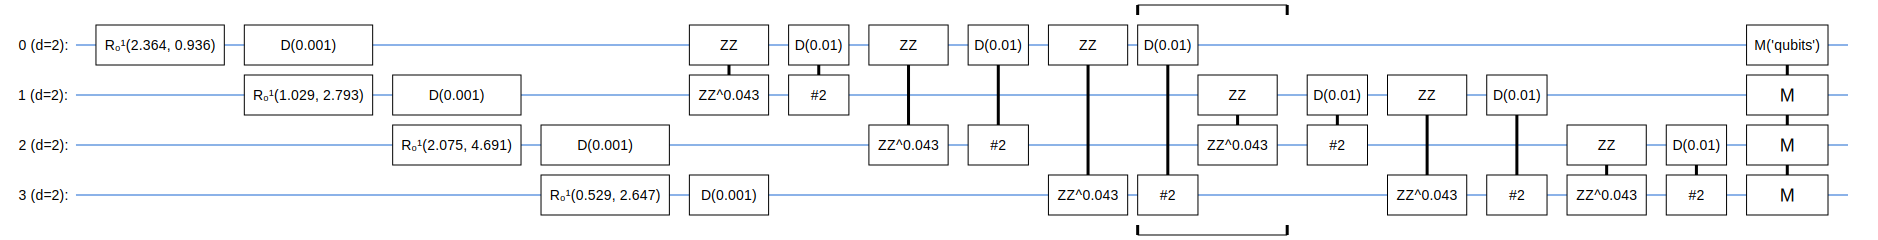

In [ ]:
num_layers = 1  # number of variational layers
num_qubits = 4
num_qubits_pairs = int((num_qubits + 1) * num_qubits / 2)

tl = np.random.uniform(low=0, high=2 * np.pi, size=(num_layers, num_qubits))
pl = np.random.uniform(low=0, high=2 * np.pi, size=(num_layers, num_qubits))
tqtl = np.random.uniform(low=0, high=2 * np.pi, size=num_layers)

print('Qubit Variational Ansatz')
qubit_vqc = qubit_variational_qc(tl, pl, tqtl, num_layers, num_qubits, measurement=True, with_noise=True)
SVGCircuit(qubit_vqc)

In [ ]:
simulator = cirq.DensityMatrixSimulator()

qubit_results = simulator.run(qubit_vqc, repetitions=10)
qubit_results.histogram(key='qubits', fold_func= lambda bits: ''.join(map(str, bits)))

Counter({'1010': 7, '0010': 1, '1000': 1, '1110': 1})

In [ ]:
qubit_energy_hist = qubit_results.histogram(key='qubits')
qubit_energy_hist

Counter({10: 7, 2: 1, 8: 1, 14: 1})

##Qudit VQC


Qudit Variational Ansatz


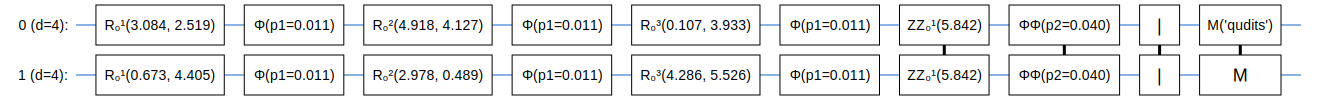

In [ ]:
num_layers = 1  # number of variational layers
num_qudits = 2
num_qudits_pairs = int((num_qudits + 1) * num_qudits / 2)

tl = np.random.uniform(low=0, high=2 * np.pi, size=(num_layers, 3, num_qudits))
pl = np.random.uniform(low=0, high=2 * np.pi, size=(num_layers, 3, num_qudits))
tqtl = np.random.uniform(low=0, high=2 * np.pi, size=(num_layers, num_qudits_pairs))

print('Qudit Variational Ansatz')
qudit_vqc = variational_qc(tl, pl, tqtl, num_layers, num_qudits, measurement=True, with_noise=True)
SVGCircuit(qudit_vqc)

In [ ]:
tl, pl, tqtl

(array([[[3.08401459, 0.67277234],
         [4.91770153, 2.97775365],
         [0.10742119, 4.28559411]]]), array([[[2.51874646, 4.4052508 ],
         [4.12707229, 0.48858005],
         [3.93253423, 5.5258535 ]]]), array([[5.84204591, 4.33778666, 0.35380771]]))

In [ ]:
qudit_results = simulator.run(qudit_vqc, repetitions=10)
qudit_results.histogram(key='qudits', fold_func= lambda bits: ''.join(map(str, bits)))

Counter({'12': 9, '11': 1})

##Reshape pararameters list

params = [5.40201612 6.19613908 1.81627593 2.35166191 3.0695103  4.21089722
 0.02537752 5.64820573 5.34561752]

theta_list = [[5.40201612 6.19613908 1.81627593 2.35166191]]
phi_list = [[3.0695103  4.21089722 0.02537752 5.64820573]]
tqt_list = [5.34561752]


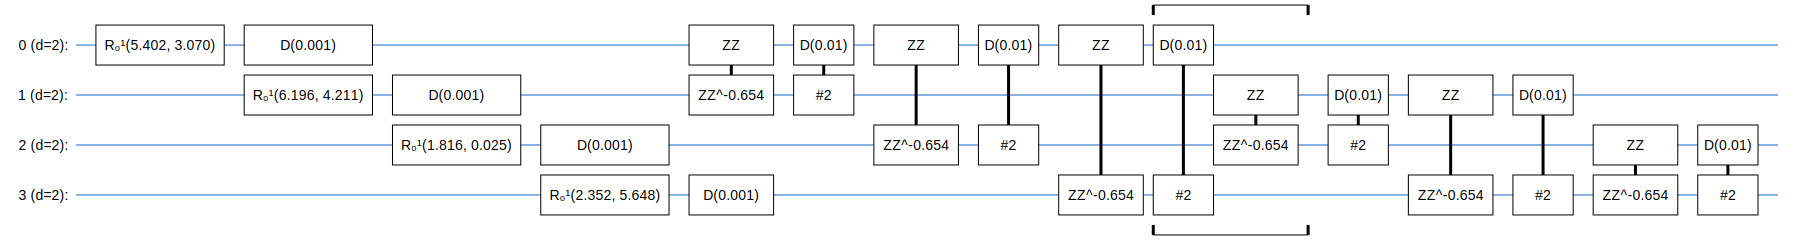

In [ ]:
def qubit_parameters_reshape(params):
        # Parameters reshape
        tl = np.array([params[:num_qubits]])
        pl = np.array([params[num_qubits : 2 * num_qubits]])
        tqtl = np.array([params[-1]])

        return tl, pl, tqtl

num_qubits = 4
num_layers = 1

params = np.random.uniform(low=0, high=2 * np.pi, size= num_qubits * 2 + 1)
print(f'params = {params}')
print()
tl, pl, tqtl = qubit_parameters_reshape(params)
print(f'theta_list = {tl}')
print(f'phi_list = {pl}')
print(f'tqt_list = {tqtl}')

qubit__vqc = qubit_variational_qc(tl, pl, tqtl, num_layers, num_qubits, measurement=False, with_noise=True)
SVGCircuit(qubit__vqc)

params = [0.94383694 4.7248098  5.45697788 4.89529836 1.24830691 4.24920837
 5.20589918 3.14187612 5.93463843 2.99889259 2.41834169 2.14226769
 1.14771936]

theta_list = [array([[0.94383694, 4.7248098 ],
       [5.45697788, 4.89529836],
       [1.24830691, 4.24920837]])]
phi_list = [array([[5.20589918, 3.14187612],
       [5.93463843, 2.99889259],
       [2.41834169, 2.14226769]])]
tqt_list = [array([1.14771936])]



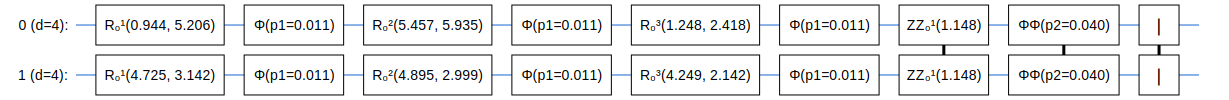

In [ ]:
def qudit_parameters_reshape(params):
    tl = [params[:num_qudits * 3].reshape((3, num_qudits))]
    pl = [params[num_qudits * 3:2 * num_qudits * 3].reshape((3, num_qudits))]
    tqtl = [params[2 * num_qudits * 3:]]

    return tl, pl, tqtl

num_qudits = 2
num_layers = 1

params = np.random.uniform(low=0, high=2 * np.pi, size= num_qudits * 6 + 1)
print(f'params = {params}')
print()
tl, pl, tqtl = qudit_parameters_reshape(params)
print(f'theta_list = {tl}')
print(f'phi_list = {pl}')
print(f'tqt_list = {tqtl}')
print()
qudit__vqc = variational_qc(tl, pl, tqtl, num_layers, num_qudits, measurement=False, with_noise=True)
SVGCircuit(qudit__vqc)

## Ising problem instanse


\begin{equation}
    H =  - J\sum\limits_i {S_i^zS_{i + 1}^z - B\sum\limits_i {S_i^x} }
\end{equation}

\begin{equation}
    S = -1, 1
\end{equation}

\begin{equation}
    H =  - \frac{J}{4}\sum\limits_i {\sigma_i^z\sigma_{i + 1}^z - \frac{B}{2}\sum\limits_i {\sigma_i^x} }
\end{equation}

\begin{equation}
    \sigma = 0, 1
\end{equation}

Create Ising interaction matrix

In [ ]:
n_qubits = 4
qubits = [cirq.LineQubit(i) for i in range(n_qubits)]

J = np.zeros((n_qubits, n_qubits))

for i in range(n_qubits):
    J[i][(i + 1) % n_qubits] = -np.random.rand() # np.random.rand()

J

array([[ 0.        , -0.36598893,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.31812738,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.31991082],
       [-0.80685527,  0.        ,  0.        ,  0.        ]])

field multiplicator

In [ ]:
h_i = np.random.rand(n_qubits) * 6
h_i

array([1.06749531, 0.67723765, 1.00578307, 2.1779759 ])

Objective function that takes a list of variational parameters and returns Ising energy

In [ ]:
def ising_hamiltonian(B):    
    hamiltonian = 0
    for i1 in range(len(qubits)):
        hamiltonian += -0.25  * complex(J[i1][(i1 + 1) % n_qubits]) * cirq.Z(qubits[i1]) * cirq.Z(qubits[(i1 + 1) % n_qubits])
        
        hamiltonian += -0.5 * complex(B) * h_i[i1] * cirq.X(qubits[i1])
    
    return hamiltonian

print(ising_hamiltonian(3))

0.091*Z(q(0))*Z(q(1))-1.601*X(q(0))+0.080*Z(q(1))*Z(q(2))-1.016*X(q(1))+0.080*Z(q(2))*Z(q(3))-1.509*X(q(2))+0.202*Z(q(0))*Z(q(3))-3.267*X(q(3))


In [ ]:
initial_rho = np.zeros((16, 16))
initial_rho[0][0] += 1

In [ ]:
def objective_function(params, J, B, num_qubits, dimension, rho, show_qc=False, with_noise=True):

    if dimension == 2:
        tl, pl, tqtl = qubit_parameters_reshape(params)
        vqe_circuit = qubit_variational_qc(tl, pl, tqtl, 1, num_qubits, measurement=False, with_noise=with_noise)

    elif dimension == 4:
        tl, pl, tqtl = qudit_parameters_reshape(params)
        vqe_circuit = variational_qc(tl, pl, tqtl, 1, num_qudits, measurement=False, with_noise=with_noise)

    if show_qc:
        print(vqe_circuit)

    #Simulate
    rho = simulator.simulate(vqe_circuit, initial_state=initial_rho).final_density_matrix
    qmap = {q:i for i, q in enumerate(qubits)}
    expectation = ising_hamiltonian(B).expectation_from_density_matrix(rho, qmap).real

    return expectation / 4

qubits

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
num_layers = 1  # number of variational layers
num_qubits = 4
dimension = 2

B = 0
params = np.random.uniform(low=0, high=2 * np.pi, size= num_qubits * 2 + 1)
objective_function(params, J, B, num_qubits, dimension, initial_rho, show_qc=True)

                                                                                                                                                 ┌───────────────┐
0 (d=2): ───R₀¹(4.133, 4.753)───D(0.001)────────────────────────────────────────────────────ZZ─────────D(0.01)───ZZ─────────D(0.01)───ZZ──────────D(0.01)────────────────────────────────────────────────────────────────
                                                                                            │          │         │          │         │           │
1 (d=2): ───────────────────────R₀¹(1.680, 6.208)───D(0.001)────────────────────────────────ZZ^0.105───#2────────┼──────────┼─────────┼───────────┼──────ZZ──────────D(0.01)───ZZ─────────D(0.01)────────────────────────
                                                                                                                 │          │         │           │      │           │         │          │
2 (d=2): ───────────────────────────────────────────R₀¹(4.749, 5.

-0.0011684813513899504

qudits

In [ ]:
num_layers = 1
num_qudits = 2
dimension = 4

B = 0
params = np.random.uniform(low=0, high=2 * np.pi, size= num_qudits * 6 + 1)
objective_function(params, J, B, num_qudits, dimension, initial_rho, show_qc=True)

0 (d=4): ───R₀¹(3.192, 4.741)───Φ(p1=0.011)───R₀²(0.593, 0.501)───Φ(p1=0.011)───R₀³(1.592, 0.157)───Φ(p1=0.011)───ZZ₀¹(2.842)───ΦΦ(p2=0.040)───|───
                                                                                                                  │             │              │
1 (d=4): ───R₀¹(3.766, 3.901)───Φ(p1=0.011)───R₀²(2.385, 4.965)───Φ(p1=0.011)───R₀³(3.279, 3.606)───Φ(p1=0.011)───ZZ₀¹(2.842)───ΦΦ(p2=0.040)───|───


-0.09181631315859626

##Optimization - Noise

In [ ]:
def corrected_rho(A):

    # hermitize
    B = (A + A.conj().T) / 2

    # add positive definiteness
    C = 1e-6 * np.identity(len(B))

    # correct trace
    D = C / np.trace(C)

    return D

### Exact numerical solution

VQE train function

In [ ]:
def train(b_field, max_layers, n_qubits, dimension, n_initial, verbose=False, with_noise=False):
    
    layers_energy = []
    rho = initial_rho
    
    for layer in range(1, max_layers + 1):

        cost_energy = []
        angles = []

        for ii in range(n_initial):
            #print counter
            if verbose:
                print()
                print(f'Layer = {layer}, random initizalization {ii}')
            
            # randomly initialize variational parameters within appropriate bounds
            np.random.seed(ii)
            if dimension == 2:
                params_size = num_qubits * 2 + 1
            elif dimension == 4:
                params_size = num_qudits * 6 + 1
            
            #initial params
            if ii == 0:
                params0 = np.zeros(params_size).tolist()
            else:
                params0 = np.random.uniform(low=0, high=2 * np.pi, size=params_size).tolist()

            bnds = [(0, 2 * np.pi) for _ in range(int(len(params0)))]

            # run classical optimization
            if dimension == 2:
                result = minimize(objective_function, params0, args=(J, b_field, num_qubits, dimension, rho), 
                            method='Nelder-Mead', bounds=bnds, options={'maxiter': 100})
            elif dimension == 4:
                result = minimize(objective_function, params0, args=(J, b_field, num_qudits, dimension, rho), 
                            method='Nelder-Mead', bounds=bnds, options={'maxiter': 100})
            

            # store result of classical optimization
            result_energy = result.fun
            cost_energy.append(result_energy)
            result_angle = result.x
            angles.append(result_angle)
            if verbose:
                print('Optimal avg energy:', result_energy)
                print('Optimal angles:', result_angle)
                print()
        
        # store energy minimum (over different initial configurations)
        energy_min = np.min(cost_energy)
        optim_angles = angles[np.argmin(cost_energy)]
        if verbose:
            print()
            print('Energy per initial seeds:', cost_energy)
            print('Best energy:', energy_min)
            print('Best angles:', optim_angles)
            print()
        
        layers_energy.append(energy_min)
        
        # Parameters reshape
        if dimension == 2:
            tl, pl, tqtl = qubit_parameters_reshape(optim_angles)
            vqe_circuit = qubit_variational_qc(tl, pl, tqtl, 1, num_qubits, measurement=False, with_noise=with_noise)
        elif dimension == 4:
            tl, pl, tqtl = qudit_parameters_reshape(optim_angles)
            vqe_circuit = variational_qc(tl, pl, tqtl, 1, num_qudits, measurement=False, with_noise=with_noise)
        
        # VQE circuit simulation-
        rho = simulator.simulate(vqe_circuit, initial_state=rho).final_density_matrix

        print('Not corrected')
        print(f'trace_rho = {np.trace(rho)}')
        print(f'np.max(rho - rho.conj().T) = {np.max(rho - rho.conj().T)}')
        print(f'eigval_rho = {np.linalg.eig(rho)[0]}')

        rho = corrected_rho(rho)

        print('Corrected')
        print(f'trace_rho = {np.trace(rho)}')
        print(f'np.max(rho - rho.conj().T) = {np.max(rho - rho.conj().T)}')
        print(f'eigval_rho = {np.linalg.eig(rho)[0]}')
        
    return layers_energy

Some settings

In [ ]:
max_layers = 4
n_initial = 4
verbose = False

Linspace of B values for optimization

In [ ]:
B_values = 2 ** np.linspace(0, 3, 10) - 1
B_values

array([0.        , 0.25992105, 0.58740105, 1.        , 1.5198421 ,
       2.1748021 , 3.        , 4.0396842 , 5.34960421, 7.        ])

We can numerically solve for GS energy of TIM

In [ ]:
def exact_solution(B):

    if B == 0:
        return -0.25

    l_value = 1 / (2 * B)
    gs_energy = 0
    
    # numerical integration
    step_size = 0.0001
    k_values = np.arange(0, np.pi, step_size)
    integration_values = [step_size * np.sqrt(1 + l_value ** 2 + 2 * l_value * np.cos(ki)) for ki in k_values]
    integral = np.sum(integration_values)
    gs_energy = 1 * integral / (4 * np.pi*l_value)
    
    return -1 * gs_energy

In [ ]:
results_exact = [exact_solution(B) for B in B_values]

### Classical optimization qubits d = 2
 

In [ ]:
num_qubits = 4
dimension = 2

In [ ]:
variational_results = []

for B in B_values:
    result = train(B, max_layers, num_qubits, dimension, n_initial,
                verbose=verbose)
    variational_results.append(result)

    print(f'B = {B}')
    print(result)
    print()

Not corrected
trace_rho = (0.9999997019767761+3.166292117384728e-08j)
np.max(rho - rho.conj().T) = (3.725290298461914e-09-7.450580596923828e-09j)
eigval_rho = [ 9.9999964e-01+3.1387636e-08j -2.2034243e-09+2.8807026e-10j
  1.3863033e-10-7.3249167e-12j -9.3462599e-12-5.7972377e-12j
  1.5977771e-12+3.7457087e-13j -1.2858868e-13-5.4267182e-14j
 -4.3867816e-14+9.1818465e-15j  1.8639865e-14+6.4292930e-15j
  2.7506601e-16+3.0687257e-16j  2.3591196e-17+5.5319857e-17j
  7.4256243e-18-1.1154126e-17j -3.7965977e-18-3.5474215e-18j
  1.2820287e-19+2.0220420e-19j -1.3364456e-19-1.3208076e-19j
 -1.3568093e-22-9.6244224e-23j -1.1139500e-22+7.9775011e-23j]
Corrected
trace_rho = 1.0
np.max(rho - rho.conj().T) = 0.0
eigval_rho = [0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]


KeyboardInterrupt: ignored

### Classical optimization qudits d = 4
 

In [ ]:
num_qudits = 2
dimension = 4

In [ ]:
qudit_variational_results = []

for B in B_values:
    result = train(B, max_layers, num_qudits, dimension, n_initial,
                verbose=verbose)
    qudit_variational_results.append(result)

    print(f'B = {B}')
    print(result)
    print()

##Result log

In [ ]:
variational_results_filename = "vary_noisy_variational_results.csv"
qudit_variational_results_filename = "vary_noisy_qudit_variational_results.csv"

In [ ]:
np.savetxt(variational_results_filename, variational_results, delimiter=",")
np.savetxt(qudit_variational_results_filename, qudit_variational_results, delimiter=",")

In [ ]:
variational_results = np.genfromtxt(variational_results_filename, delimiter=',')

qudit_variational_results = np.genfromtxt(qudit_variational_results_filename, delimiter=',')

## Comparison of exact and variational solutions

In [ ]:
plt.figure(figsize=(16, 10))

plt.plot(B_values, results_exact, 'k--s', label='Exact results')

for n_layers in range(1, max_layers + 1):
    plt.plot(B_values, [result[n_layers - 1] for result in variational_results], '-s', label=f'VQE: d=2, N = {n_layers} layers')
    plt.plot(B_values, [result[n_layers - 1] for result in qudit_variational_results], '-s', label=f'VQE: d=4, N = {n_layers} layers')

plt.title('Benchmarking VQE ansatz with exact solutions', fontsize=15)
plt.xlabel(r'Magnetic field $B$ / $J$ ', fontsize=15)
plt.ylabel('Ground state energy per particle $E_{0}$ / $N$', fontsize=15)
plt.grid()
plt.legend(fontsize=25)

plt.savefig('vary_noisy_vqe_qubits.png')

Relative error of VQE algorithm

\begin{equation}
    \eta = \left|\frac{E_{VQE} - E_{0}} {E_{0}}\right|
\end{equation}

In [ ]:
plt.figure(figsize=(16, 10))

for n_layers in range(1, max_layers + 1):
    qubit_eta = []
    for i in range(len(B_values)):
        qubit_eta = qubit_eta + [np.abs(([result[n_layers - 1] for result in variational_results][i] - results_exact[i - 1]) / results_exact[i - 1]) ]
    plt.plot(B_values, qubit_eta, '-s', label=f'VQE: d=2, N = {n_layers} layers')


    qudit_eta = []
    for i in range(len(B_values)):
        qudit_eta = qudit_eta + [np.abs(([result[n_layers - 1] for result in qudit_variational_results][i] - results_exact[i - 1]) / results_exact[i - 1]) ]
    plt.plot(B_values, qudit_eta, '-s', label=f'VQE: d=4, N = {n_layers} layers')

plt.title(r'$\eta$ ratio VQE ansatz with exact solutions', fontsize=15)
plt.xlabel(r'Magnetic field $B$ / $J$ ', fontsize=15)
plt.ylabel(r'$\eta = \left|\frac{E_{VQE} - E_{0}} {E_{0}}\right|$', fontsize=15)
plt.grid()
plt.legend(fontsize=25)

plt.savefig('noisy_vqe_eta.png')

### Layerwise progress:



In [ ]:
B_value_index = 5

In [ ]:
qubit_layer_score = []

for result in variational_results[B_value_index]:
    eta = np.abs((result - results_exact[B_value_index]) / results_exact[B_value_index])  
    qubit_layer_score.append(eta)

qudit_layer_score = []

for result in qudit_variational_results[B_value_index]:
    eta = np.abs((result - results_exact[B_value_index]) / results_exact[B_value_index])  
    qudit_layer_score.append(eta)


In [ ]:
plt.figure(figsize=(16, 10))

x = list(range(len(qubit_layer_score)))

plt.plot(x, qubit_layer_score, '-sb', label=f'qubit VQE: d=2, B = {B_values[B_value_index]}')
plt.plot(x, qudit_layer_score, '-sg', label=f'qudit VQE: d=4, B = {B_values[B_value_index]}')

plt.title(r'Score layer dependency without noise', fontsize=15)
plt.xlabel(r'Layer $N$', fontsize=15)
plt.ylabel(r'$\eta = \left|\frac{E_{VQE} - E_{0}} {E_{0}}\right|$', fontsize=15)
plt.grid()
plt.legend(fontsize=25)


### Layerwise loop 

In [ ]:
for B_value_index in range(len(B_values)):
    qubit_layer_score = []

    for result in variational_results[B_value_index]:
        eta = np.abs((result - results_exact[B_value_index]) / results_exact[B_value_index])  
        qubit_layer_score.append(eta)

    qudit_layer_score = []

    for result in qudit_variational_results[B_value_index]:
        eta = np.abs((result - results_exact[B_value_index]) / results_exact[B_value_index])  
        qudit_layer_score.append(eta)


    plt.figure(figsize=(16, 10))

    x = list(range(len(qubit_layer_score)))

    plt.plot(x, qubit_layer_score, '-sb', label=f'qubit VQE: d=2, B = {B_values[B_value_index]}')
    plt.plot(x, qudit_layer_score, '-sg', label=f'qudit VQE: d=4, B = {B_values[B_value_index]}')

    plt.title(r'Score layer dependency without noise', fontsize=15)
    plt.xlabel(r'Layer $N$', fontsize=15)
    plt.ylabel(r'$\eta = \left|\frac{E_{VQE} - E_{0}} {E_{0}}\right|$', fontsize=15)
    plt.grid()
    plt.legend(fontsize=25)